# OAM 3He Experiment:
***

In [23]:
import numpy as np
import sympy as sym
import scipy as sc
import matplotlib.pyplot as plt
import mcstasscript as ms
import scienceplots
import time, math, os
from scipy.optimize import curve_fit
from scipy.signal import hilbert,convolve,find_peaks,savgol_filter
from scipy.fft import fft,fftfreq,ifft
from scipy.integrate import quad,simpson
from scipy.interpolate import CubicSpline
from matplotlib.animation import FuncAnimation, PillowWriter
from itertools import islice

plt.style.use(['science', 'notebook', 'grid', 'default', 'bright'])
plot_height = 8
plot_width = plot_height*1.618

np.set_printoptions(suppress=True)

SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 10,15,20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)
plt.rcParams.update({'axes.grid':True})

plt.rc('text', usetex=False)
if False: #Additions to latex preamble for matplotlib:
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsthm,amssymb,amsfonts,braket,siunitx}')
    plt.rcParams["font.family"] = "Computer Modern Roman"
sym.init_printing()

gN = -1.832471e8    #gyromagnetic ratio of neutron (rad/T/m^2)
mN = 1.674927e-27    #mass of neutron (kg)
hbar = 1.054571e-34    #plancks constant (kg m^2/s)
cL = gN/(hbar*2*np.pi)*mN*1e-10    #Larmor phase constant (T^-1 m^-1 AA^-1)
print(f'Larmor constant = {round(cL*1e10,3):.3e}')

Larmor constant = -4.632e+14


In [41]:
def get_sem(B1, L1, L2):
    """Returns focusing condition for prism in regular SEMSANS."""
    if L1 <= L2: raise ValueError('L1 > L2!')
    B = [B1*L1/L2]
    return bp.array(B)

def shim_cos(x,amp,freq,phase,shim):
    """Returns linear frequency cosine with phase and offset."""
    return amp*np.cos(x*freq + phase) + shim

def cos(x,amp,freq,phase):
    """Returns linear frequency cosine with phase."""
    return amp*np.cos(x*freq + phase)

def get_flip(gpa,lam,dist,flip=np.pi):
    """Current for pi or pi/2 flip."""
    return round(flip/(1e-4*gpa*CL*lam*dist*1e-2),2)

def get_sec(sel=100,sep=.11,lam=4.25,gpa=30):
    """Current for given spin echo length (nm) for MWP."""
    return round(abs(np.pi*sel*1e-9/(1e-10*(lam)**2*cL*gpa*1e-4*sep)),2)

print(f'MWP current for 100nm: {get_sec(sel=100)} amps')

print(f'Nutator pi/2 current: {get_flip(10,4.25,3,flip=np.pi/2)} amps')

MWP current for 100nm: 11.38 amps
Nutator pi/2 current: -0.27 amps


In [58]:
lambda0 = 4.25  #Mean wavelength (AA)
dlambda = lambda0*1/100

ap_width = 10.
ap_height = 10.

MWP_str = 6e-3  #MWP field strength (T/Amp)
NU_str = 1e-3
CRYO_str = 1e-3

MWP_dims = [.02,.02,.11]
NU_dims = [.03,.03,.03]
CRYO_dims = [.03,.03,.015]

MWP_sep = .006
NU_sep = .0125 + .015
CYRO_sep = .006

N1 = .15
C1 = N1 + NU_dims[2] + NU_sep
d1 = C1 + CRYO_dims[2] + CYRO_sep
d2 = d1 + MWP_dims[2] + MWP_sep
N2 = d2 + MWP_dims[2] + NU_sep
d3 = N2 + NU_dims[2] + NU_sep
d4 = d3 + MWP_dims[2] + MWP_sep
C2 = d4 + MWP_dims[2] + CYRO_sep
N3 = C2 + CRYO_dims[2] + NU_sep
det1 = N3 + NU_dims[2] + .15    #distance from sample position to detector1 (m)
ds = det1 + .3
det2 = ds + .6  #must be shorter than 3 meters
d = [N1,C1,d1,d2,N2,d3,d4,C2,N3,det1,ds,det2]

print(MWP_dims[2]*2+MWP_sep+CYRO_sep+CRYO_dims[2]+2*NU_sep)

print(f'Wavelength: {lambda0} p/m {round(dlambda,3)}')
print(f'Aperture (mm) = {ap_width,ap_height}')
print(f'Front distances from MWP to source (m): {np.round(d,3)}')

cur = get_sec(sel=100)
print(f'MWP currents: {cur}')

pol_dir = [1,0,0]    #direction of polarizer (x,y,z)
pol_dir = [i/np.sqrt(sum([j**2 for j in pol_dir])) for i in pol_dir]    
print('Polarizer axis: ', [round(i,3) for i in pol_dir])

det_x,det_y = 10.,10.
det_bins = 128

print(f'Detector size (mm): {np.round([det_x,det_y],3)}')
print('[x,y] bin size (mm) = ', [round(i,3) for i in [det_x/det_bins,det_y/det_bins]], '\n')

print("-"*80)     #Start of instrument definition
OAM = ms.McStas_instr('OAM', author = 'Sam McKay', origin = 'Indiana University')
delta_lambda = OAM.add_parameter("double", "delta_lambda", value = dlambda, comment="Wavelength spread [AA]")
low_count = OAM.add_parameter("int", "low_count", value = 0, comment="if true flips analyzer direction [N/A]")
all_off = OAM.add_parameter("int", "all_off", value = 0, comment="if true turns off all MWPs [N/A]")
cur1 = OAM.add_parameter("double", "cur1", value = cur, comment="MWP1 current [Amps]")
cur2 = OAM.add_parameter("double", "cur2", value = -cur, comment="MWP2 current [Amps]")
cur3 = OAM.add_parameter("double", "cur3", value = cur, comment="MWP3 current [Amps]")
cur4 = OAM.add_parameter("double", "cur4", value = -cur, comment="MWP4 current [Amps]")
polx = OAM.add_parameter("double", "polx", value = pol_dir[0], comment="x-component of polarizer [N/A]")
poly = OAM.add_parameter("double", "poly", value = pol_dir[1], comment="y-component of polarizer [N/A]")
polz = OAM.add_parameter("double", "polz", value = pol_dir[2], comment="z-component of polarizer [N/A]")
OAM.show_parameters()

print("-"*80)    #Source and polarizer (collimation included via source parameters):
OAM.add_component("origin","Progress_bar")
OAM.add_component("arm","Arm", AT=[0,0,0], RELATIVE="origin")

src = OAM.add_component("src","Source_sam", AT=[0,0,0], RELATIVE="origin")
src.set_parameters(xwidth=ap_width*1e-3,yheight=ap_height*1e-3,I1=1e13,lambda0=lambda0,dlambda="delta_lambda",\
                   focus_xw=det_x/1e3,focus_yh=det_y/1e3,x_offset=det_x_offset/1e3,dist=Ld)
print(src)
pol = OAM.add_component("pol","Set_pol", AT=[0,0,1e-6], RELATIVE="origin")
pol.set_parameters(px="polx", py="poly", pz="polz")

print(pol)

print("-"*80)    #First accelerator coil and nutator
NU1 = OAM.add_component("NU1","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
NU1.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(NU1)
AC1 = OAM.add_component("AC1","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
AC1.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(AC1)

print("-"*80)    #Magnetic Wollaston prisms:
MWP1 = OAM.add_component("MWP1","pol_MWP_FI_expansion_v2", AT=[0,0,d[0]], RELATIVE="origin")
MWP1.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur1*(1-all_off)")
MWP2 = OAM.add_component("MWP2","pol_MWP_FI_expansion_v2", AT=[0,0,d[1]], RELATIVE="origin")
MWP2.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur2*(1-all_off)")
MWP3 = OAM.add_component("MWP3","pol_MWP_FI_expansion_v2", AT=[0,0,d[2]], RELATIVE="origin")
MWP3.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur3*(1-all_off)")
MWP4 = OAM.add_component("MWP4","pol_MWP_FI_expansion_v2", AT=[0,0,d[3]], RELATIVE="origin")
MWP4.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur4*(1-all_off)")
MWP1.set_ROTATED([0, 0, 0], RELATIVE="ABSOLUTE")
MWP2.set_ROTATED([0, 0, 0], RELATIVE="ABSOLUTE")
MWP3.set_ROTATED([0, 0, 90], RELATIVE="ABSOLUTE")
MWP4.set_ROTATED([0, 0, 90], RELATIVE="ABSOLUTE")
print(MWP1,'\n', MWP2)
print(MWP3, '\n', MWP4)

print("-"*80)    #Second accelerator coil and nutator
AC2 = OAM.add_component("AC2","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
AC2.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(AC2)
NU2 = OAM.add_component("NU2","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
NU2.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(NU2)

print("-"*80)    #Detectors and sample:
ana = OAM.add_component("ana","PolAnalyser_ideal", AT=[0, 0, Ld - (Ls + 2e-6)], RELATIVE="origin")
ana.set_parameters(mx=0, my=0, mz="polx*(1-2*low_count)")
ana.set_ROTATED([0, 0, 0], RELATIVE="ABSOLUTE")
print(ana)

twoD_det = OAM.add_component("twoD_det","PSD_monitor", AT=[det_x_offset/1e3, 0, Ld + 2e-6], RELATIVE="origin")
twoD_det.set_parameters(nx=det_bins, ny=det_bins, filename=twoD_file, xwidth=det_x*1e-3, yheight=det_y*1e-3)
print(twoD_det)

print("-"*80)    #Final instrument summary:
OAM.show_components()

0.302
Wavelength: 4.25 p/m 0.043
Aperture (mm) = (10.0, 10.0)
Front distances from MWP to source (m): [0.15  0.208 0.228 0.344 0.482 0.54  0.656 0.772 0.814 0.994 1.294 1.894]
MWP currents: 11.38
Polarizer axis:  [1.0, 0.0, 0.0]
Detector size (mm): [10. 10.]
[x,y] bin size (mm) =  [0.078, 0.078] 

--------------------------------------------------------------------------------
double delta_lambda  = 0.0425  // Wavelength spread [AA]
int    low_count     = 0       // if true flips analyzer direction [N/A]
int    all_off       = 0       // if true turns off all MWPs [N/A]
double cur1          = 11.38   // MWP1 current [Amps]
double cur2          = -11.38  // MWP2 current [Amps]
double cur3          = 11.38   // MWP3 current [Amps]
double cur4          = -11.38  // MWP4 current [Amps]
double polx          = 1.0     // x-component of polarizer [N/A]
double poly          = 0.0     // y-component of polarizer [N/A]
double polz          = 0.0     // z-component of polarizer [N/A]
------------

NameError: No component named Progress_bar in McStas installation or current work directory.

Currents =  [10, -11.192, 7.202, -8.394]
INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_hc_10_5"
INFO: Regenerating c-file: OAM.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_MWP_FI_expansion_v2' is a contributed component.
CFLAGS=
INFO: Recompiling: OAM.exe
OAM.c: In function 'mcuse_dir':
OAM.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
OAM.c: In function 'sighandler':
OAM.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy OAM.instr in dataset C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_hc_10_5



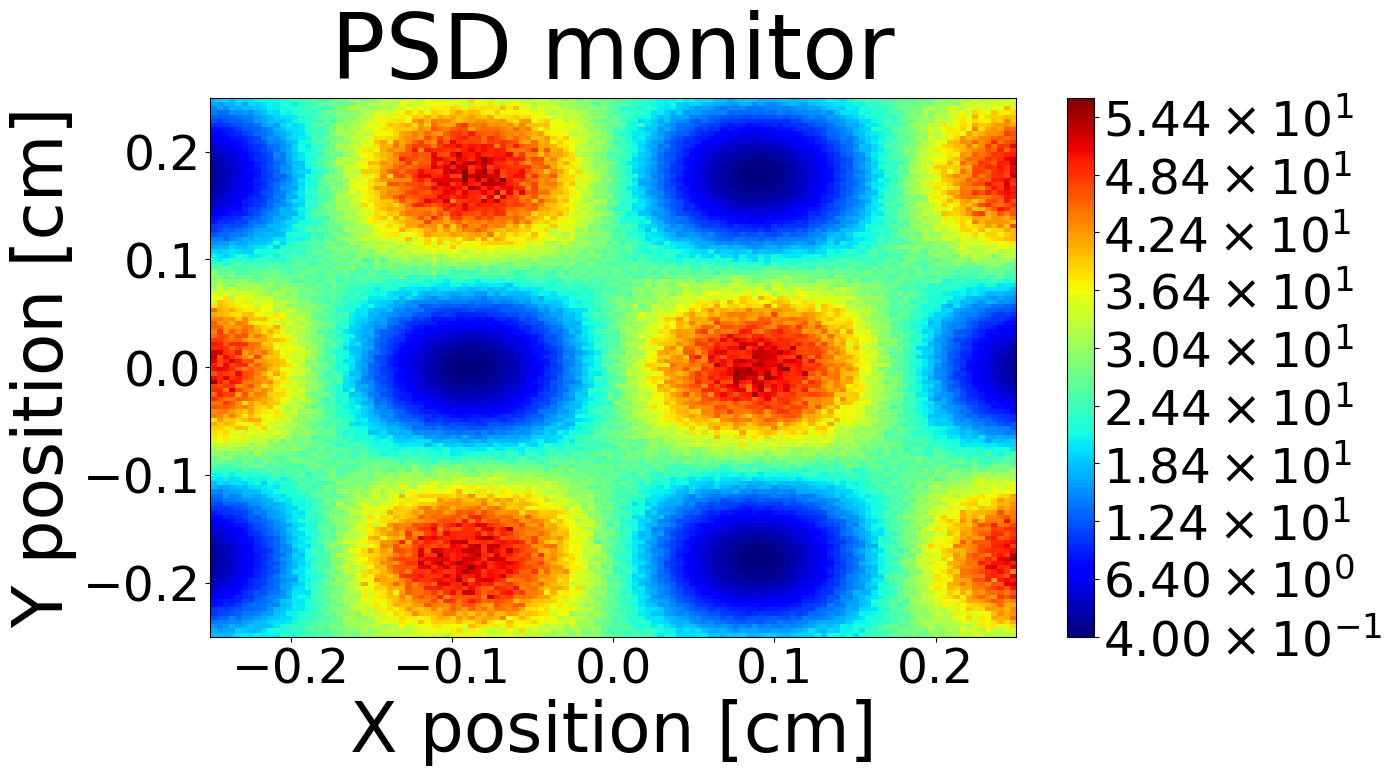

INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_lc_10_5"
INFO: Regenerating c-file: OAM.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_MWP_FI_expansion_v2' is a contributed component.
CFLAGS=
INFO: Recompiling: OAM.exe
OAM.c: In function 'mcuse_dir':
OAM.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
OAM.c: In function 'sighandler':
OAM.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy OAM.instr in dataset C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_lc_10_5


----------------------------------------

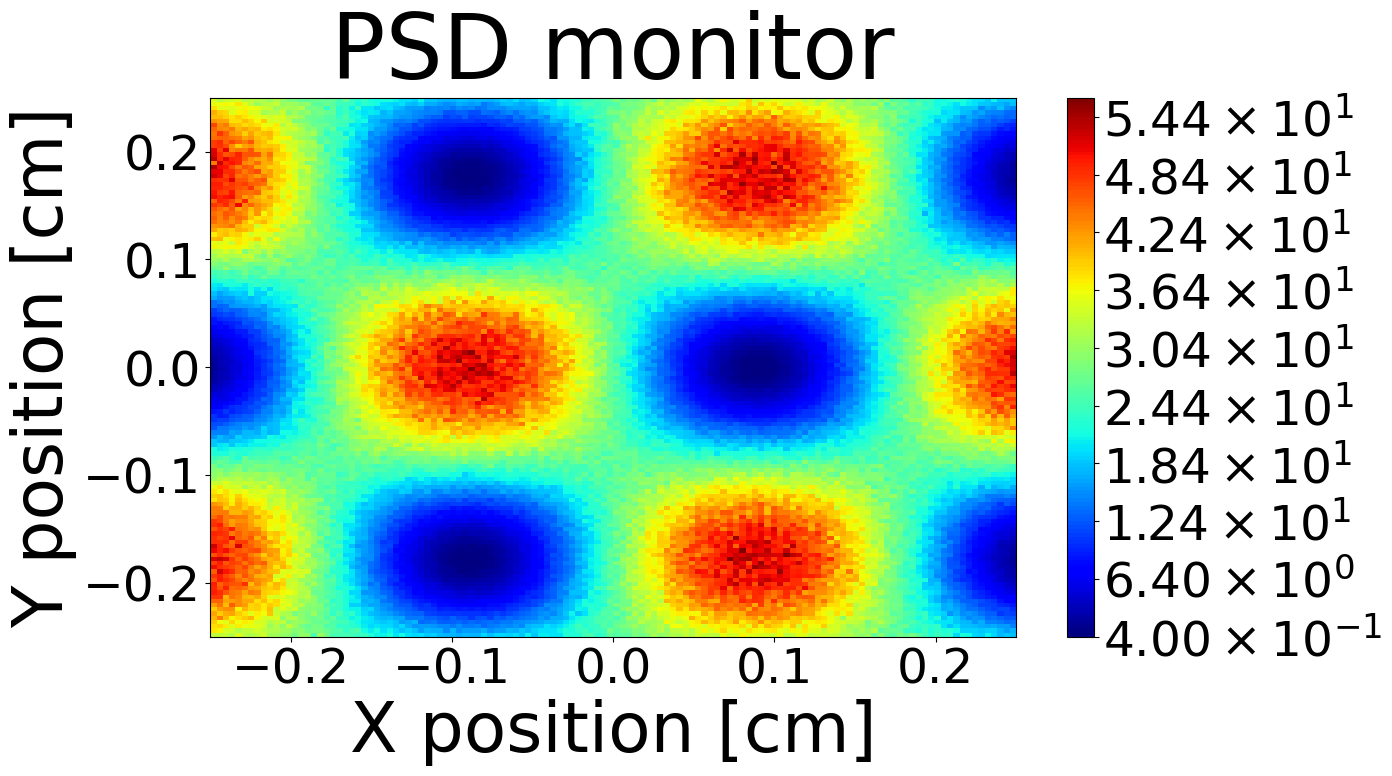


Currents =  [40, -44.768, 28.808, -33.576]
INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_hc_40_0"
INFO: Regenerating c-file: OAM.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_MWP_FI_expansion_v2' is a contributed component.
CFLAGS=
INFO: Recompiling: OAM.exe
OAM.c: In function 'mcuse_dir':
OAM.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
OAM.c: In function 'sighandler':
OAM.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy OAM.instr in dataset C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_hc_40_

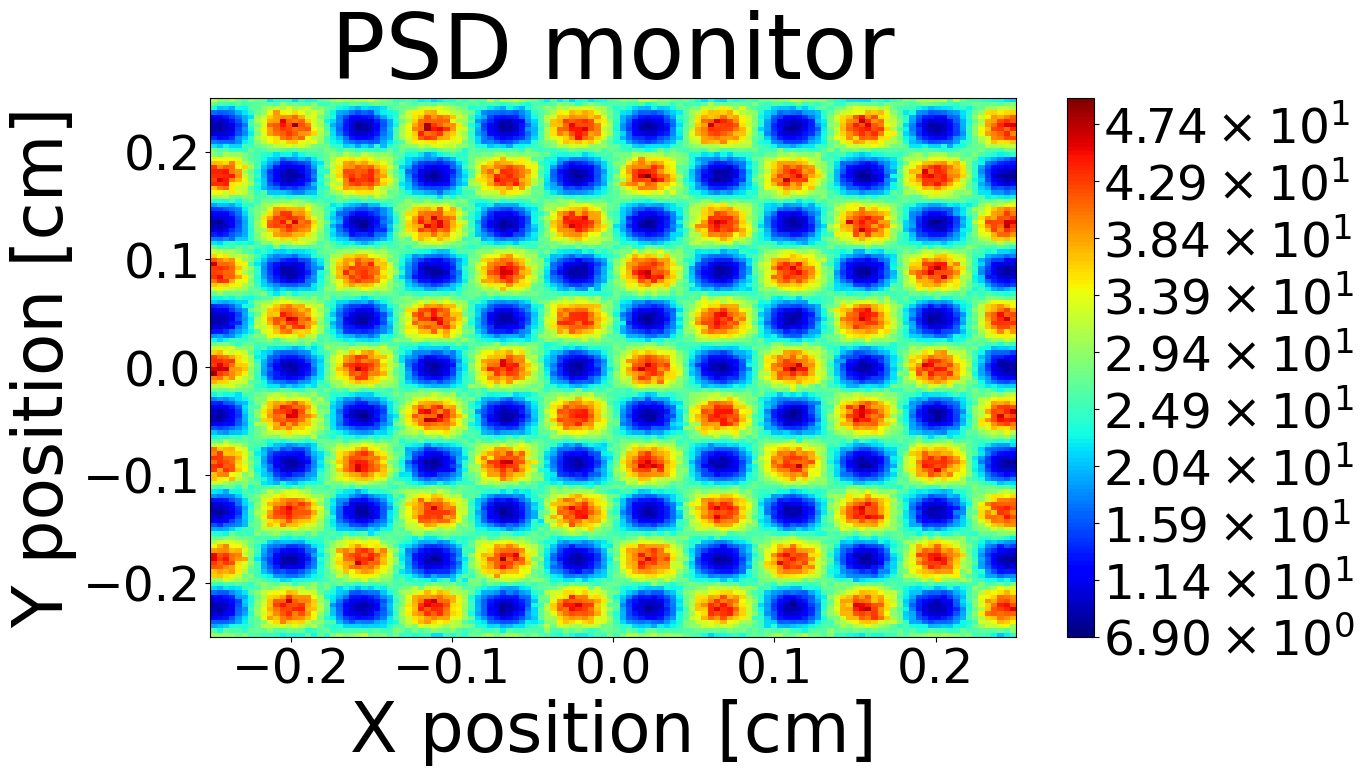

INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_lc_40_0"
INFO: Regenerating c-file: OAM.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_MWP_FI_expansion_v2' is a contributed component.
CFLAGS=
INFO: Recompiling: OAM.exe
OAM.c: In function 'mcuse_dir':
OAM.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
OAM.c: In function 'sighandler':
OAM.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy OAM.instr in dataset C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_lc_40_0


----------------------------------------

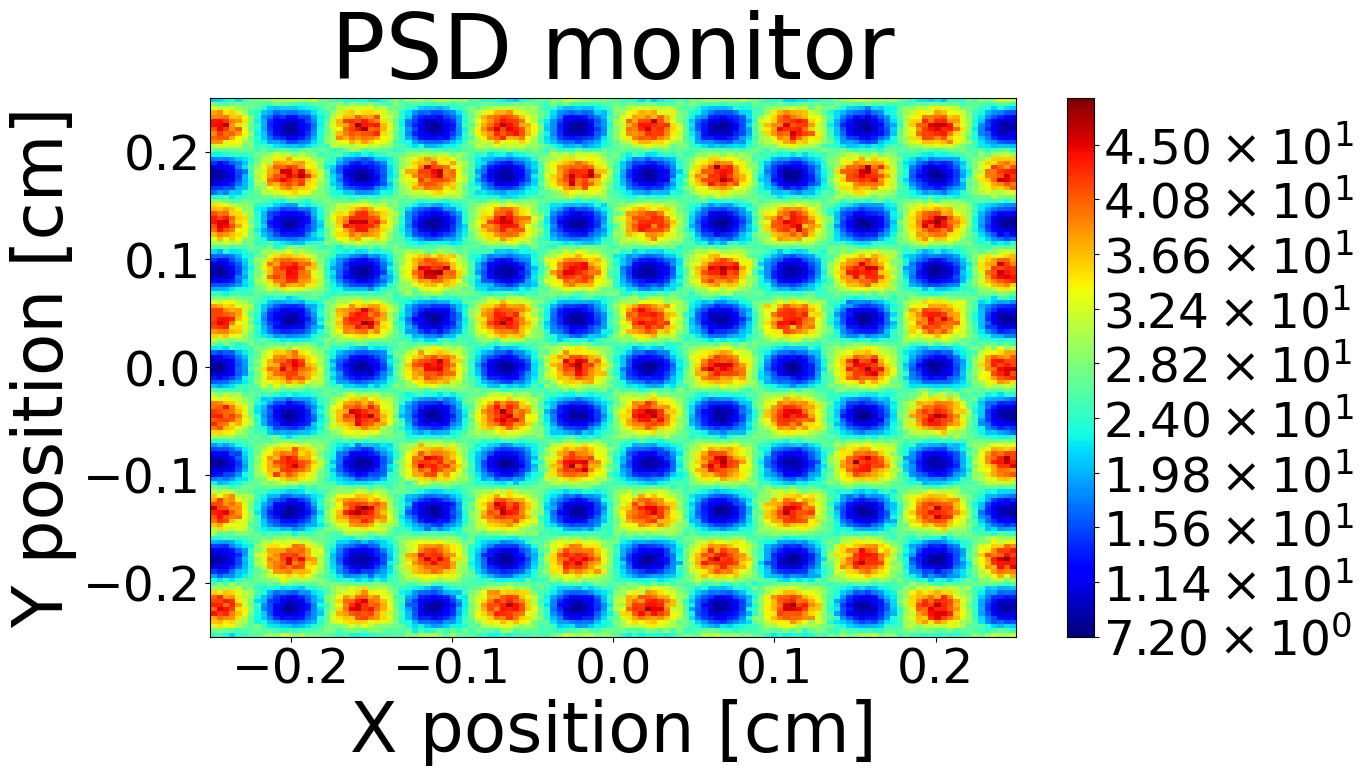

In [5]:
def do_run(ray_num, curs):
    """Runs the two necessary simulations to extract the polarization.
    Returns high and low counts and errors and all used currents."""
    used_curs = []
    hc_runs, hc_err = [[],[]]
    lc_runs, lc_err = [[],[]]

    for i in curs:
        c1 = i
        c2, c3, c4 = get_ch(i, L1, L2, L3, L4)
        used_curs.append([c1,c2,c3,c4])
        print('Currents = ', [round(i,3) for i in [c1,c2,c3,c4]])

        OAM.settings(output_path='OAM_hc_'+str(round(c1,2)), ncount=ray_num)
        low_count.value, all_off.value, cur1.value, cur2.value, cur3.value, cur4.value = 0, 0, c1, c2, c3, c4
        OAM_hc = OAM.backengine()
        hc_runs.append(OAM_hc[-1].Intensity)    #only LAST detector is returned
        hc_err.append(OAM_hc[-1].Error)
        ms.make_plot(OAM_hc)

        OAM.settings(output_path='OAM_lc_'+str(round(c1,2)))
        low_count.value = 1
        OAM_lc = OAM.backengine()
        lc_runs.append(OAM_lc[-1].Intensity)
        lc_err.append(OAM_lc[-1].Error)
        ms.make_plot(OAM_lc)
        print('='*80, '\n')
    return used_curs, hc_runs, hc_err, lc_runs, lc_err
        
used_curs, hc_runs, hc_err, lc_runs, lc_err = do_run(1e7, [10,40])


# Data Analysis

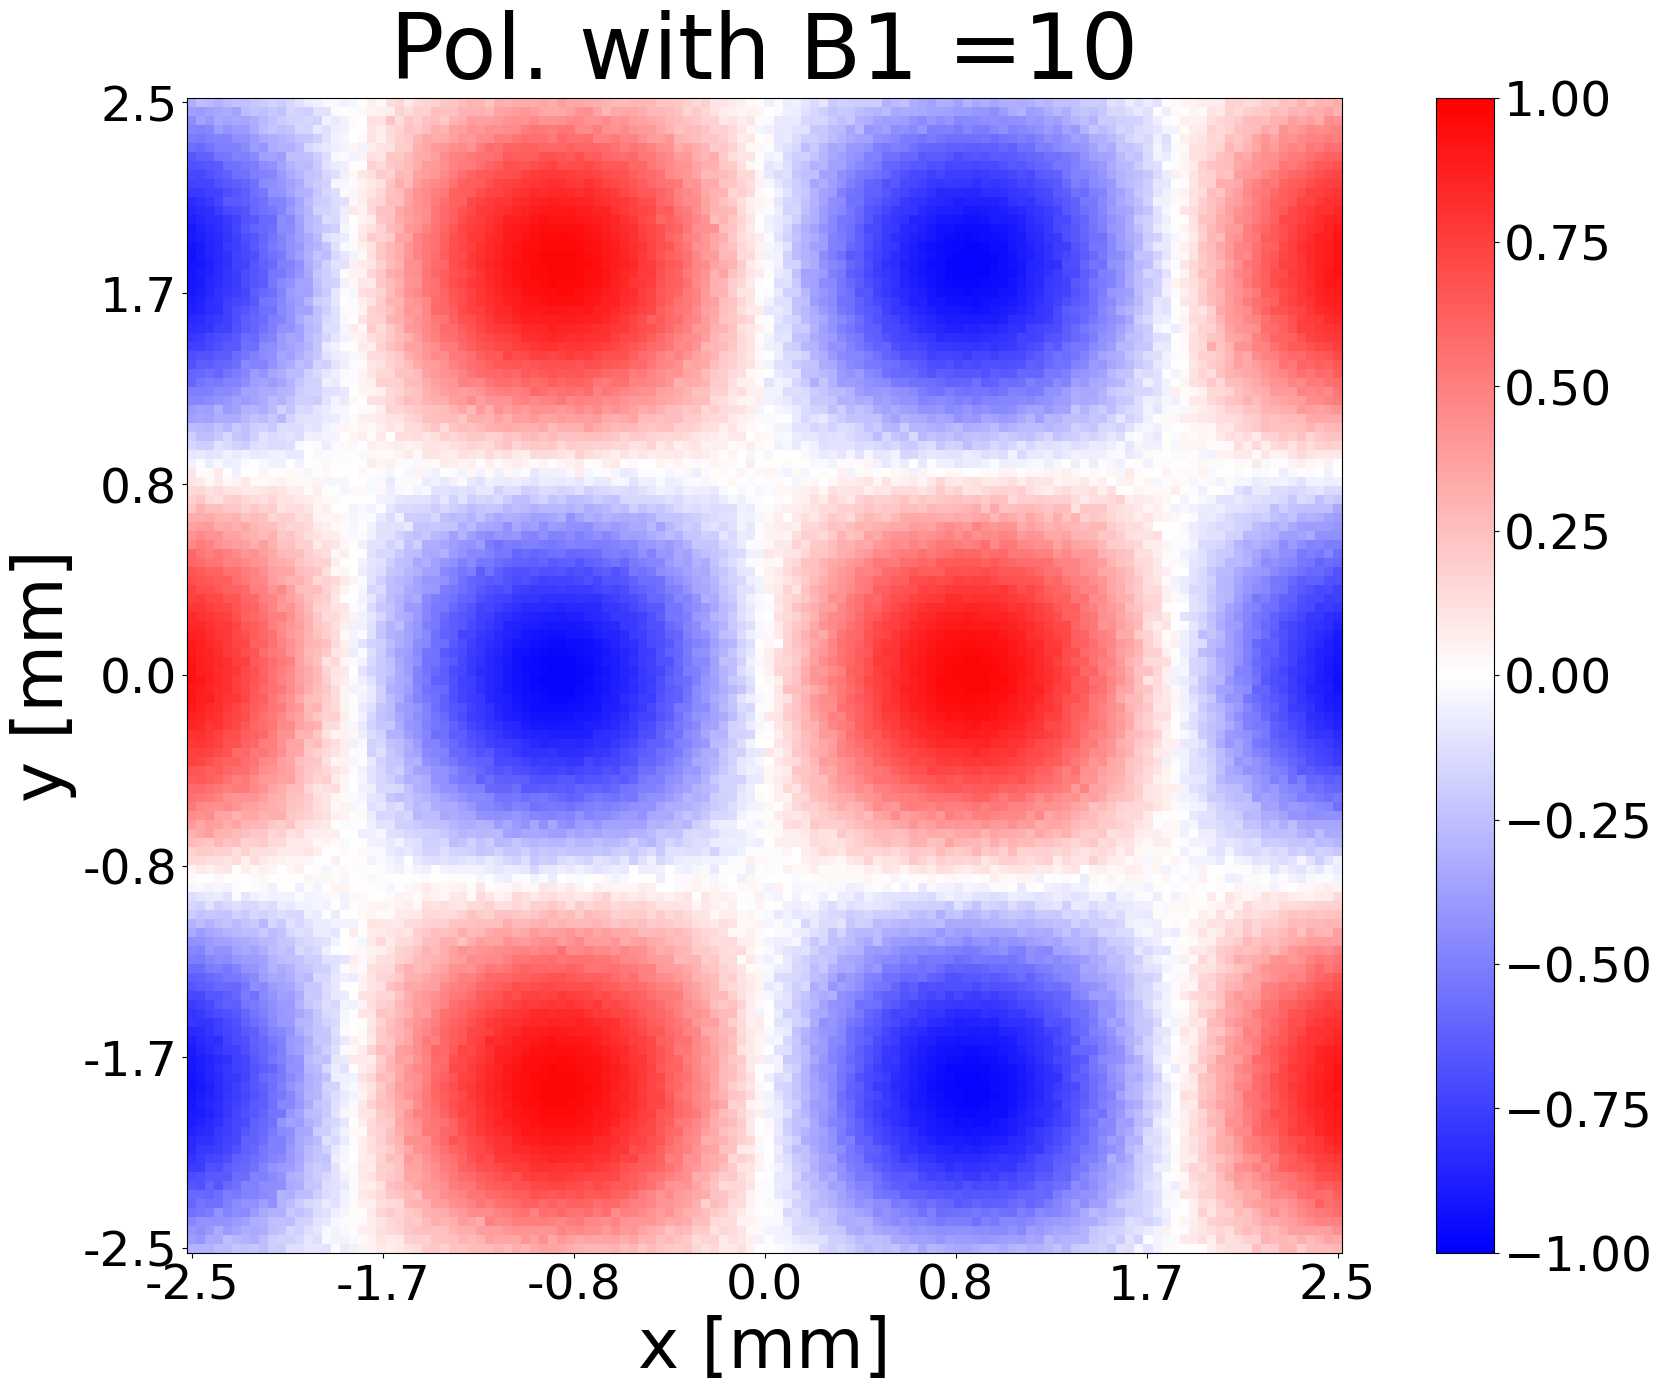

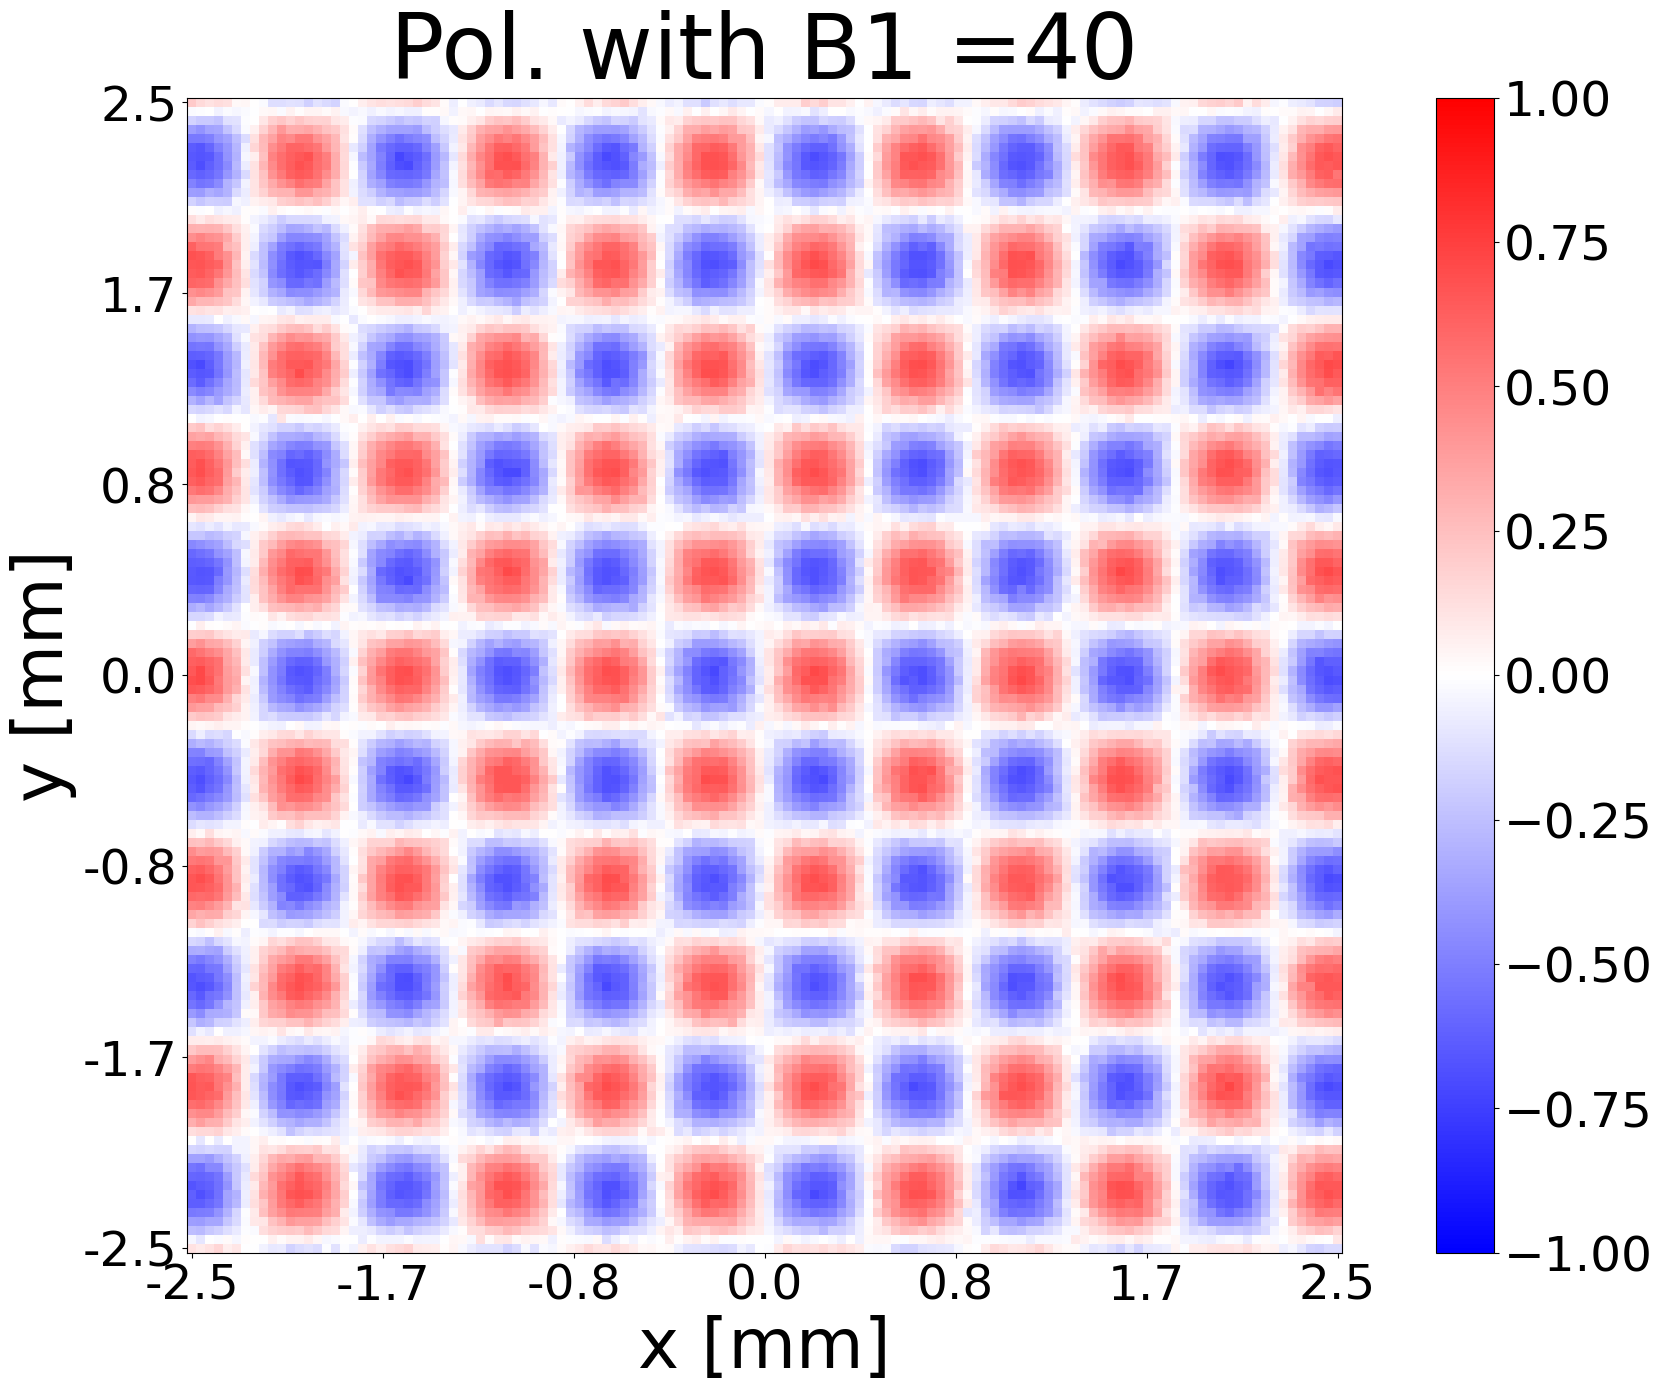

In [8]:
xpos = np.linspace(-det_x/2,det_x/2, num=det_bins, endpoint=True)
fine_bins = 200
finer_bins = 1000
xpos_fine = np.linspace(xpos[0], xpos[-1], num=fine_bins, endpoint=True)
xpos_finer = np.linspace(xpos[0], xpos[-1], num=finer_bins, endpoint=True)
pols = np.array([np.zeros((det_bins,det_bins)) for i in range(len(hc_runs))])

for i in range(len(used_curs)): #don't change this!
    for j in range(det_bins):
        for k in range(det_bins):
            pols[i][j][k] = ((hc_runs[i][j][k] - lc_runs[i][j][k])\
                             /(hc_runs[i][j][k] + lc_runs[i][j][k]))
                
    fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('Pol. with B1 ='+str(used_curs[i][0]))
    plt.imshow(pols[i], origin='lower', vmin=-1, vmax=1, interpolation='none', cmap='bwr')
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    ax.set_xticks(np.linspace(0,det_bins-1,7))
    ax.set_yticks(np.linspace(0,det_bins-1,7))
    ax.set_xticklabels([round(i,1) for i in np.linspace(-det_x/2,det_x/2,7)])
    ax.set_yticklabels([round(i,1) for i in np.linspace(-det_y/2,det_y/2,7)])
    plt.colorbar()
    plt.show()


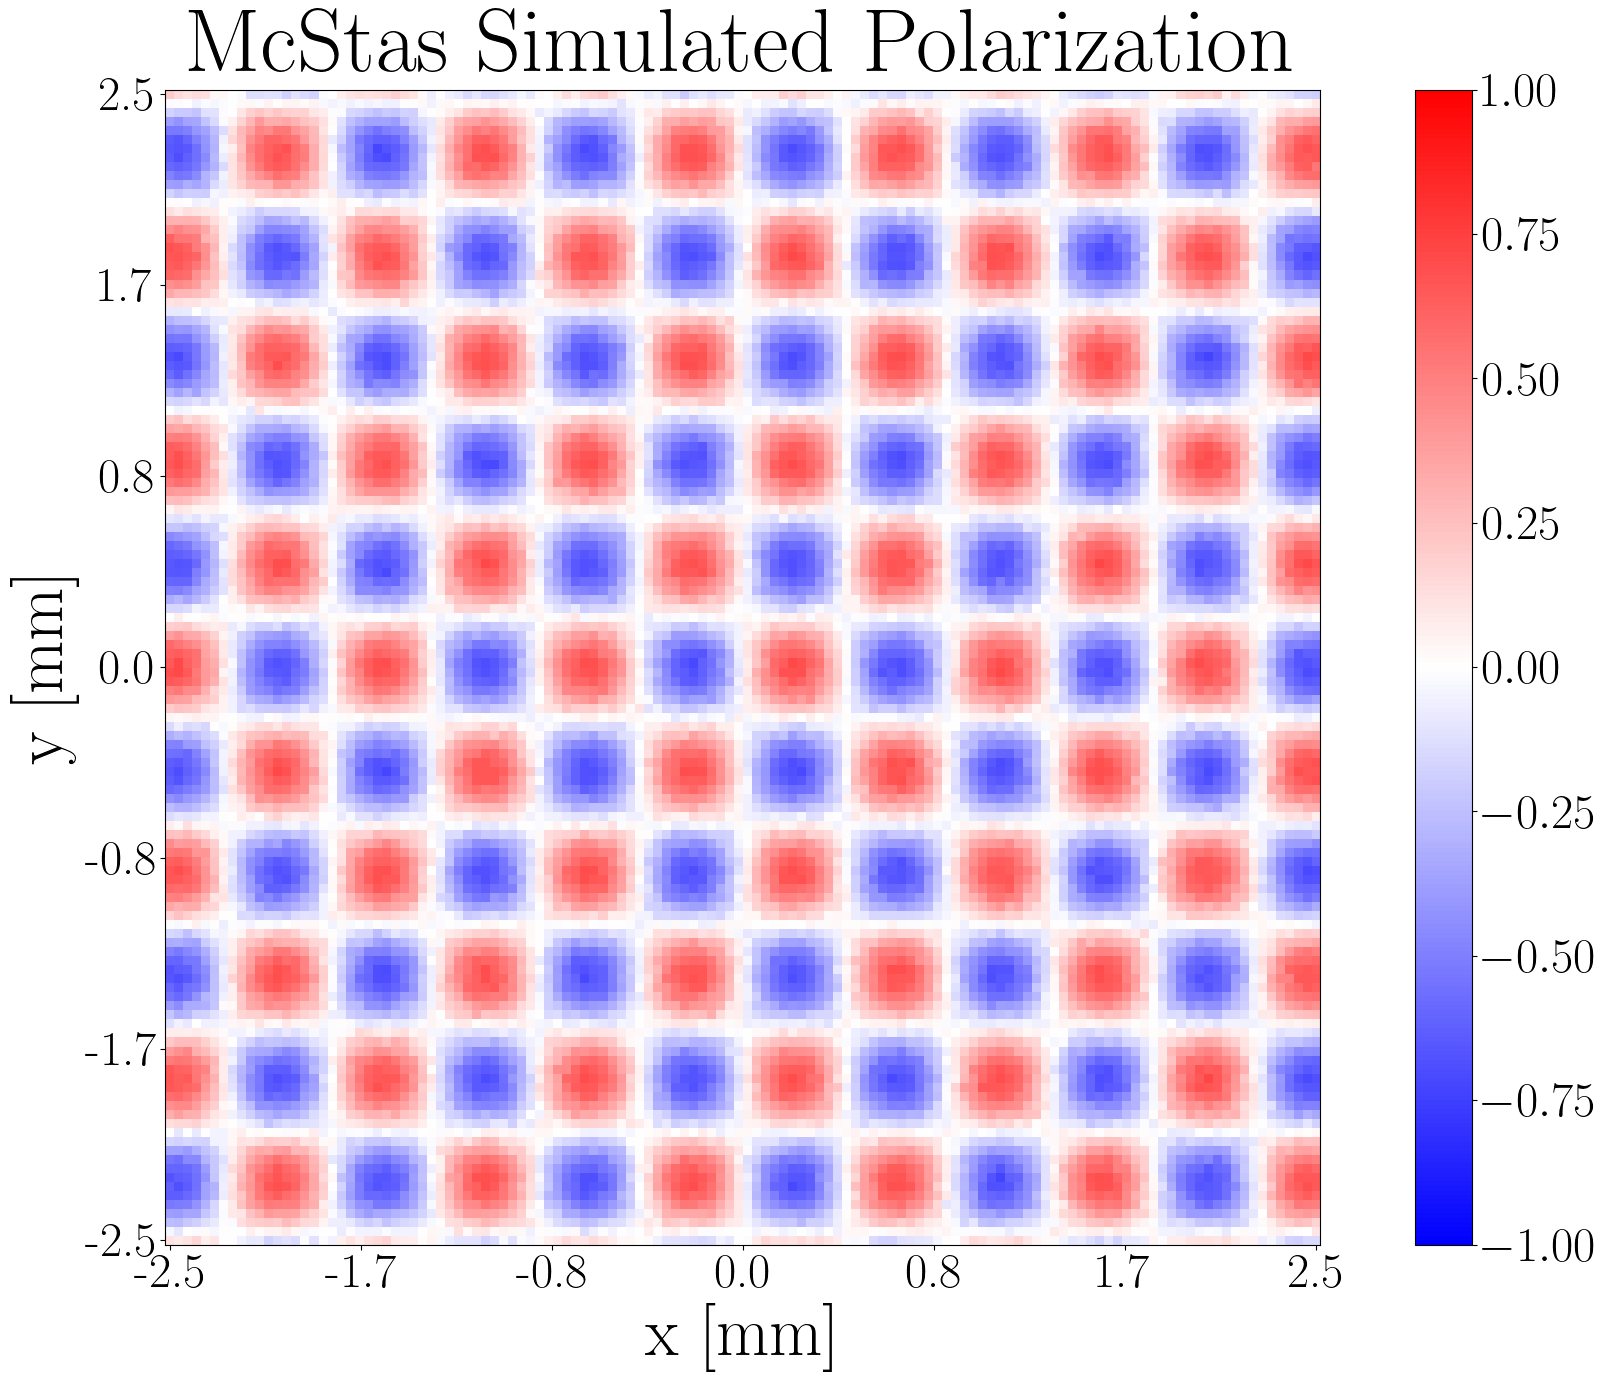

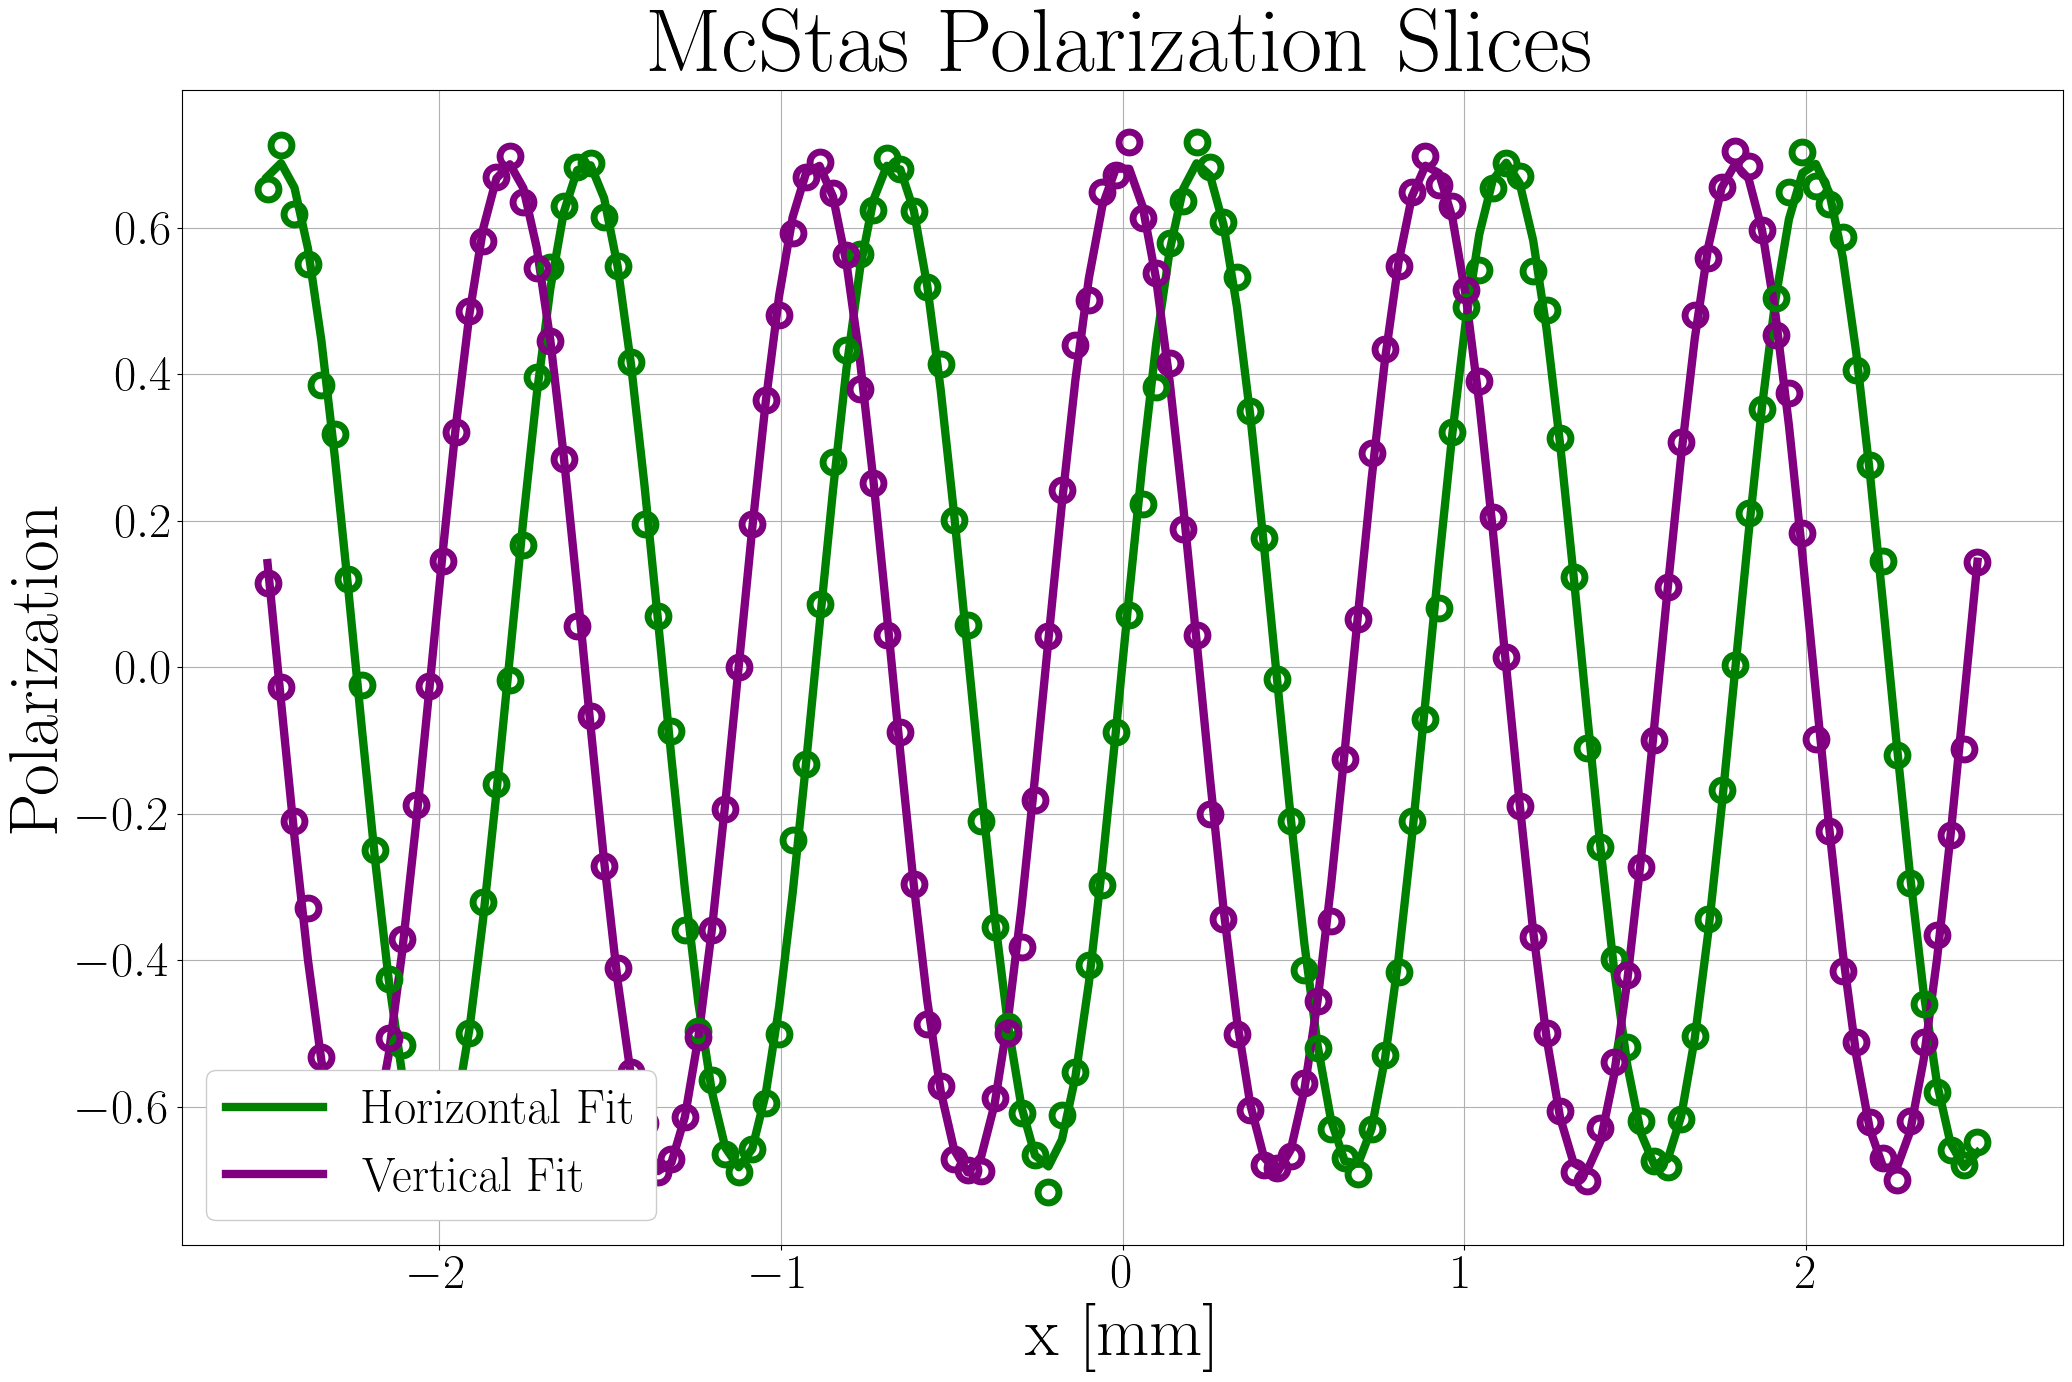

In [66]:
x_mg, y_mg = np.meshgrid(xpos, xpos)
def cb_theory(x,y,p):
    """Generates theorectical checkerboard spin-texture."""
    r_0 = p/(np.pi)
    z = -2*np.cos(2*y/r_0)*np.cos(x/r_0)*np.sin(x/r_0)
    return z

def get_p(c):
    """Returns theorectical fringe period."""
    return abs(2*np.pi/(cL*lambda0*MWP_str*(c[0] + c[1])))*1e3
cb_th = cb_theory(x_mg,y_mg,get_p(used_curs[-1]))

plot_im, plot_3D = True, False

if plot_im:
    """fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('Theory')
    plt.imshow(cb_th, origin='lower', vmin=-1, vmax=1,interpolation='none', cmap='bwr')
    plt.colorbar()
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    ax.set_xticks(np.linspace(0,det_bins-1,7))
    ax.set_yticks(np.linspace(0,det_bins-1,7))
    ax.set_xticklabels([round(i,1) for i in np.linspace(-det_x/2,det_x/2,7)])
    ax.set_yticklabels([round(i,1) for i in np.linspace(-det_y/2,det_y/2,7)])
    plt.show()"""

    fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('McStas Simulated Polarization')
    plt.imshow(pols[-1], origin='lower', vmin=-1, vmax=1, interpolation='none', cmap='bwr')
    plt.colorbar()
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    ax.set_xticks(np.linspace(0,det_bins-1,7))
    ax.set_yticks(np.linspace(0,det_bins-1,7))
    ax.set_xticklabels([round(i,1) for i in np.linspace(-det_x/2,det_x/2,7)])
    ax.set_yticklabels([round(i,1) for i in np.linspace(-det_y/2,det_y/2,7)])
    #plt.axhline(y=63.5, linewidth=5, linestyle='--', color='green')
    #plt.axvline(x=69.25, linewidth=5, linestyle='--', color='purple')
    plt.show()

    fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('McStas Polarization Slices')
    plt.plot(xpos, pols[-1][64,:], 'o', ms=15, color='green', zorder=10, markerfacecolor='none', markeredgewidth=5)
    guess = [(np.max(pols[-1][64,:])-np.min(pols[-1][64,:]))/2.,2*np.pi/1,0,np.mean(pols[-1][64,:])]
    fit, cov = sp.optimize.curve_fit(simple_cos, xpos, pols[-1][64,:], p0=guess)
    plt.plot(xpos, simple_cos(xpos, *fit), '-', linewidth=6, color='green', label='Horizontal Fit')
    
    plt.plot(xpos, pols[-1][:,69], 'o', ms=15, color='purple', zorder=15, markerfacecolor='none', markeredgewidth=5)
    guess = [(np.max(pols[-1][:,69])-np.min(pols[-1][:,69]))/2.,2*np.pi/1,0,np.mean(pols[-1][:,69])]
    fit, cov = sp.optimize.curve_fit(simple_cos, xpos, pols[-1][:,69], p0=guess)
    plt.plot(xpos, simple_cos(xpos, *fit), '-', linewidth=6, color='purple', label='Vertical Fit')
    
    plt.xlabel('x [mm]')
    plt.ylabel('Polarization')
    plt.legend(loc='lower left', framealpha=1).set_zorder(20)
    plt.grid()
    plt.show()
    
if plot_3D:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    #ax.view_init(60, 35)
    ax.contour3D(xpos,xpos,pols[0], 100, cmap='plasma')
    plt.show()

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(x_mg,y_mg,cb_th, rstride=1, cstride=1, cmap='plasma', edgecolor='none')
    plt.show()


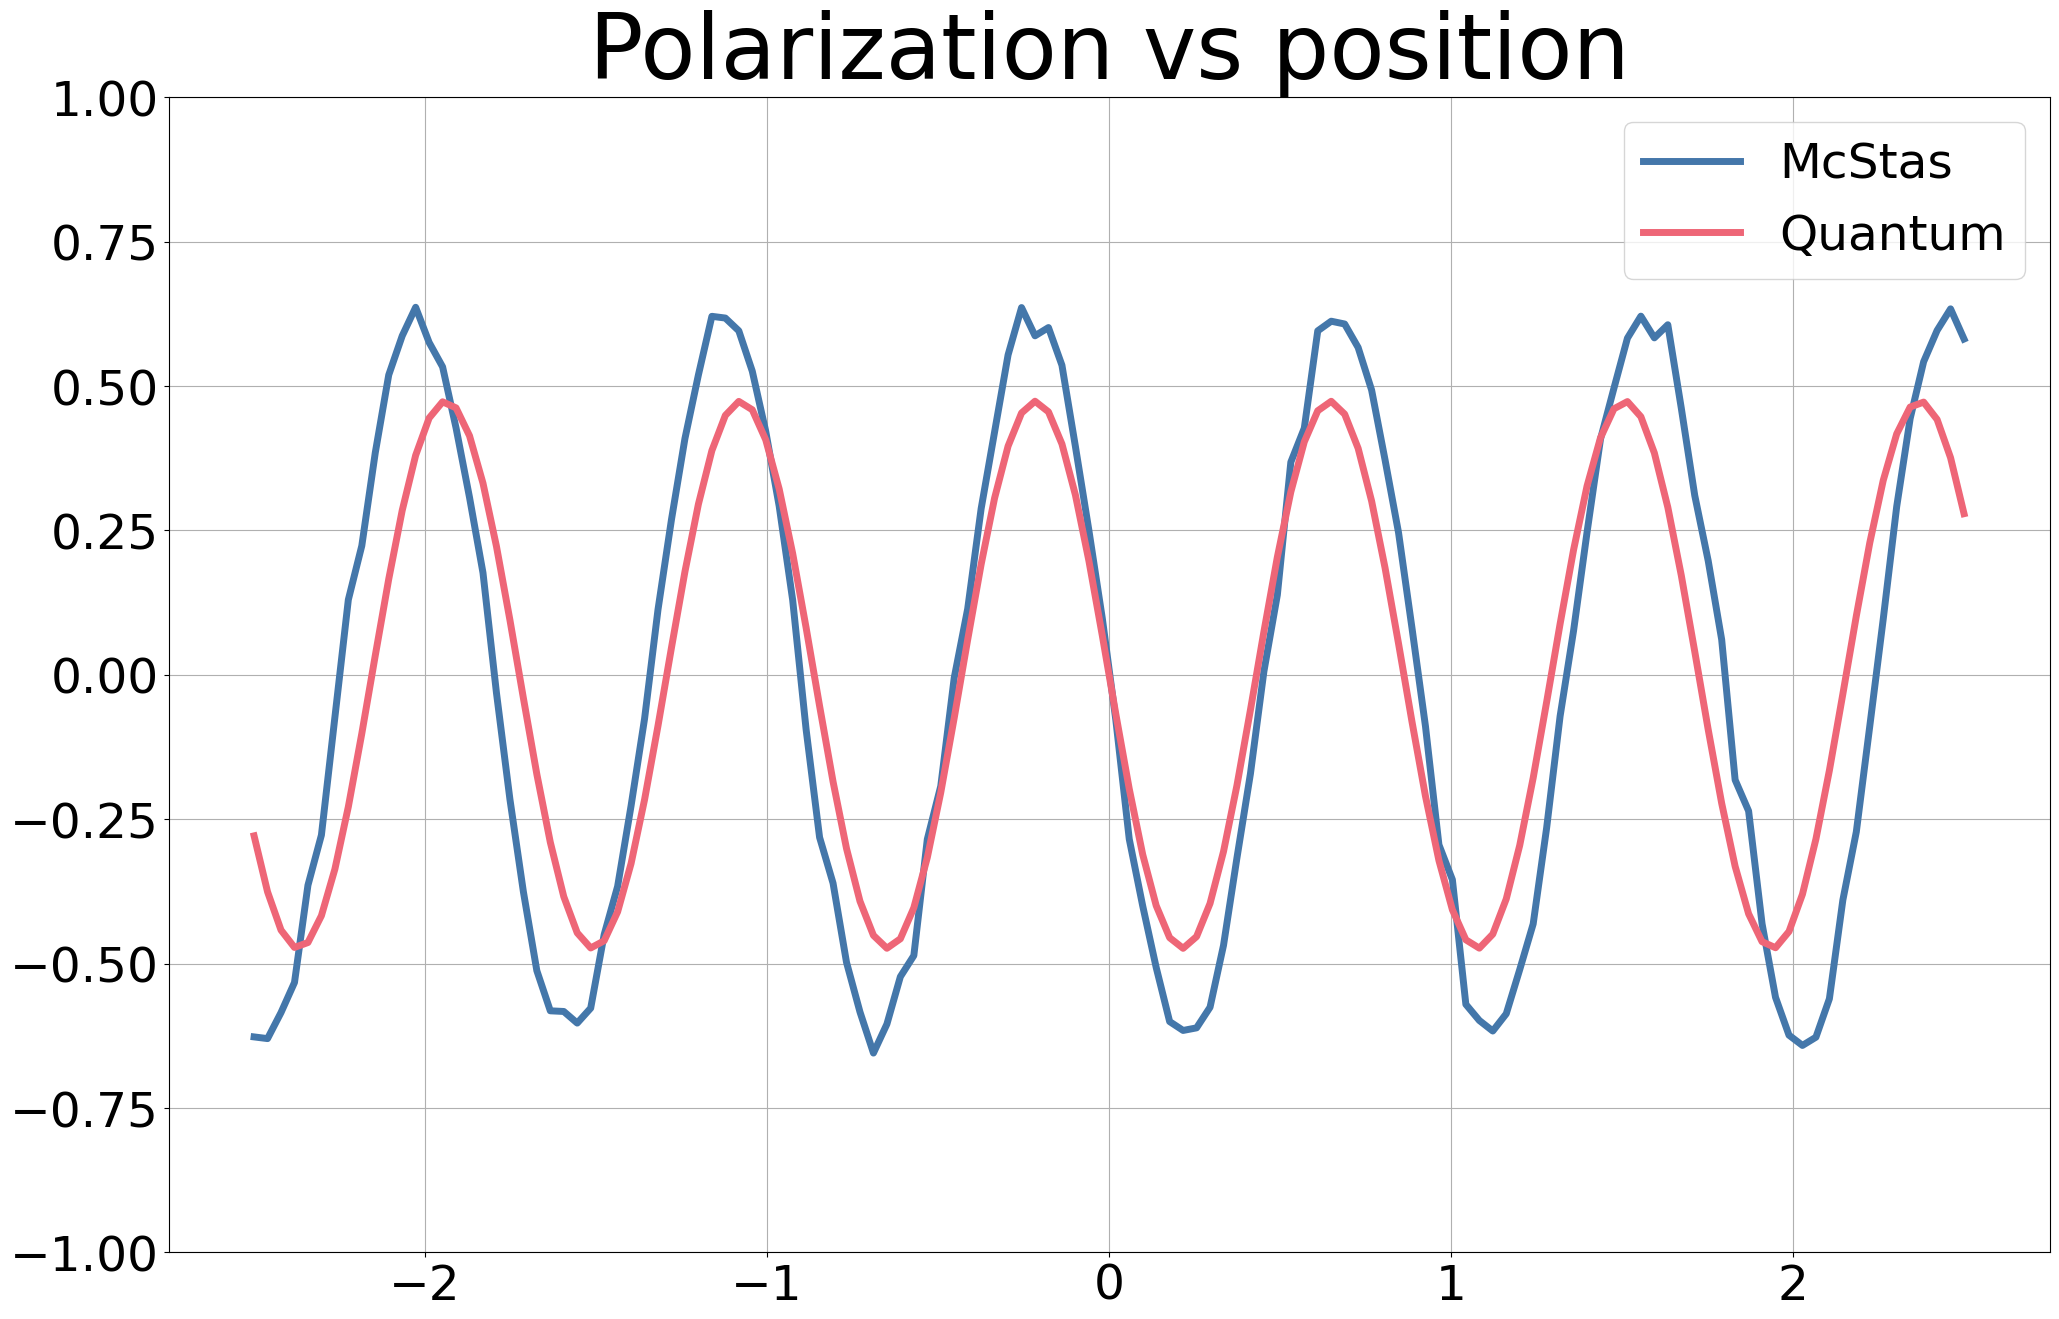

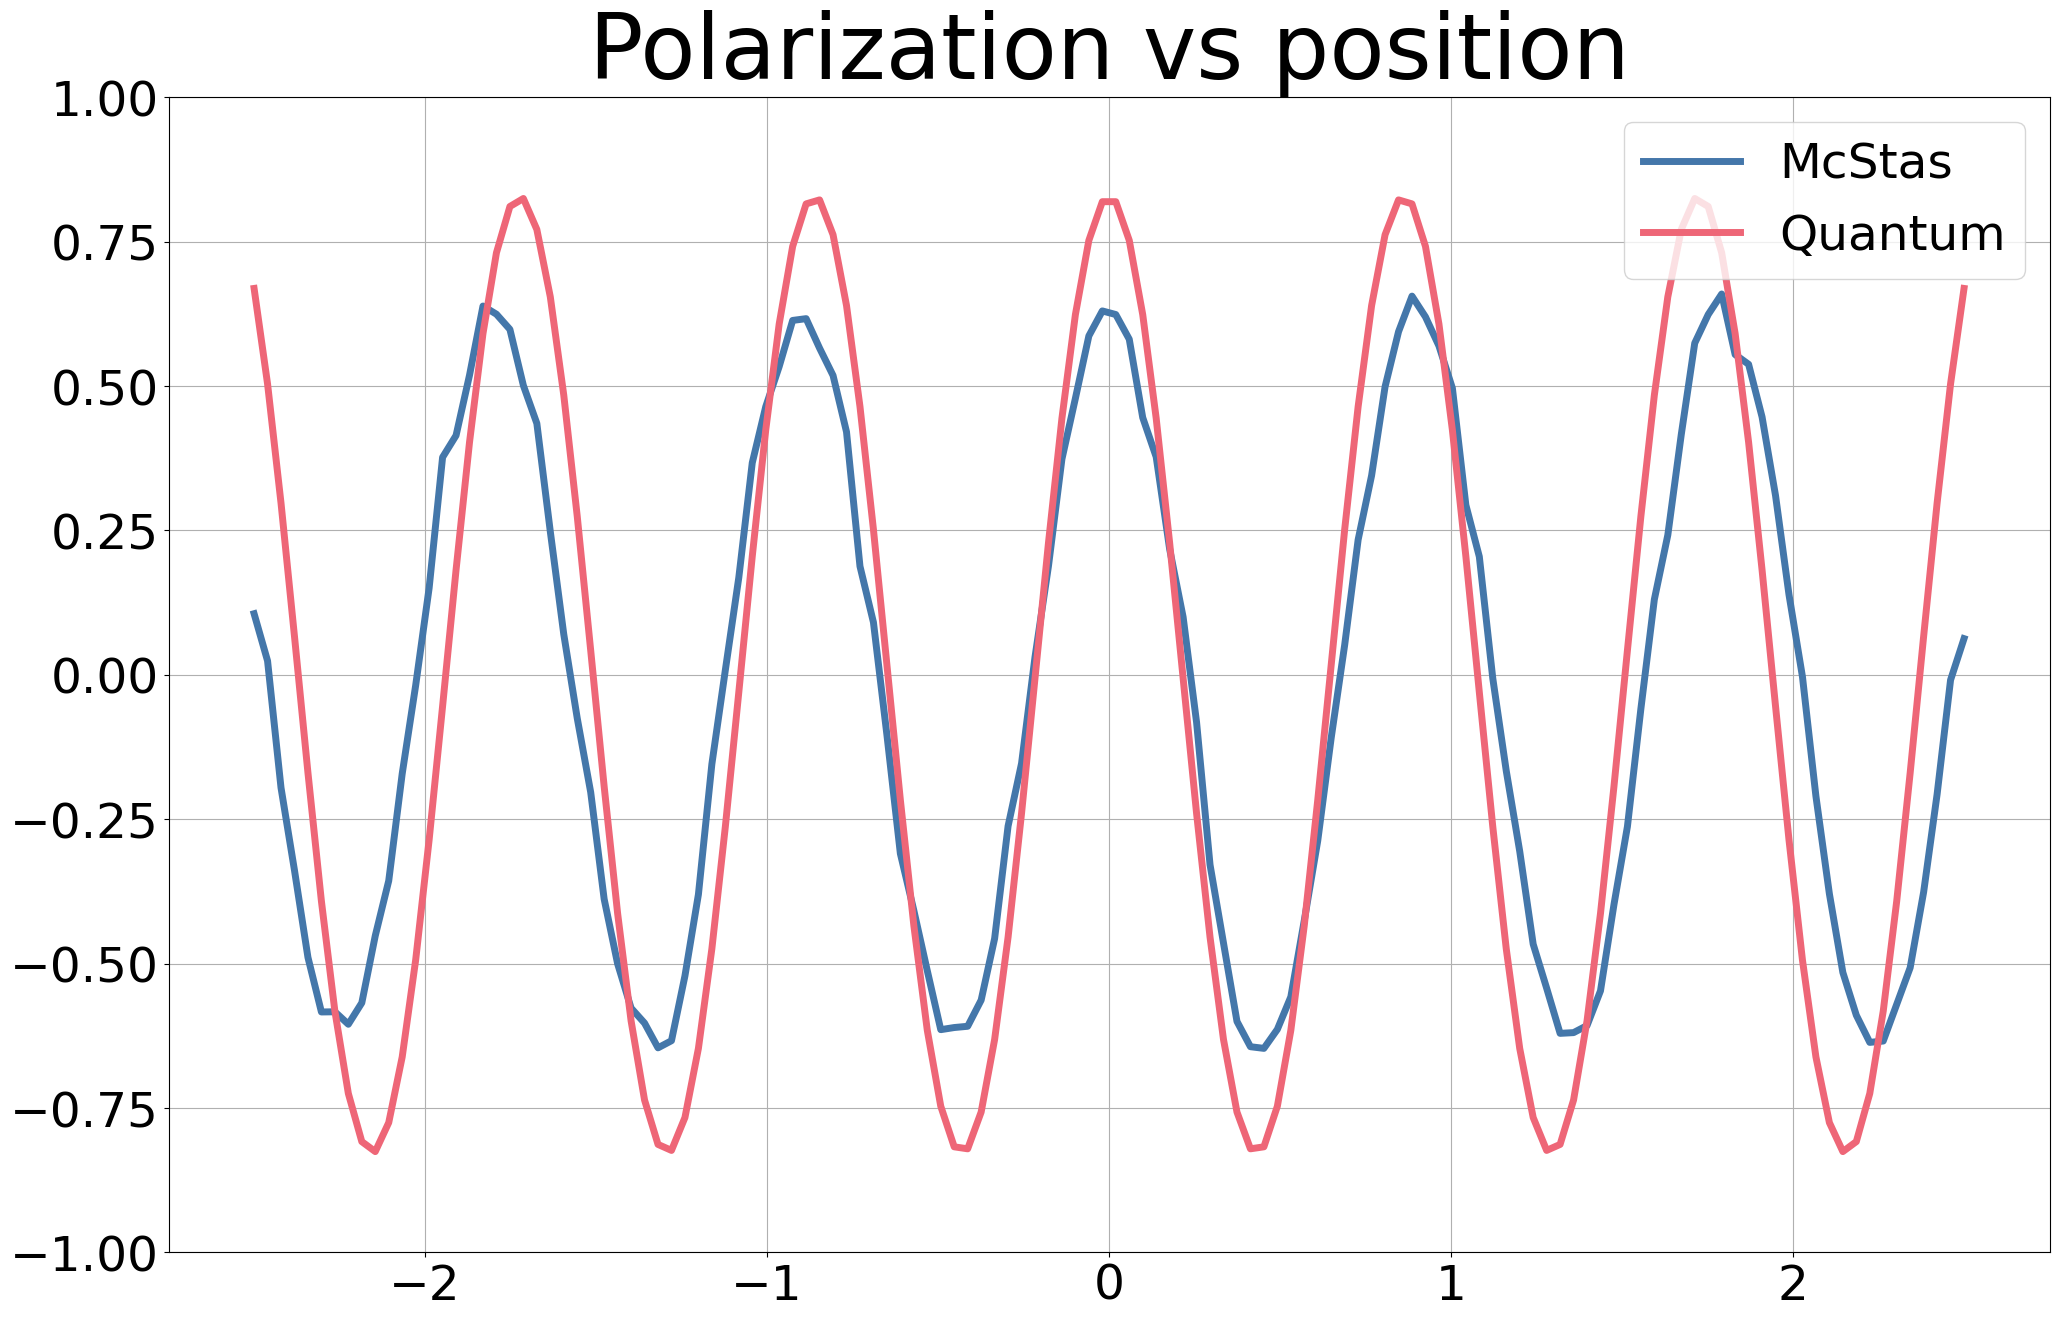

In [10]:
fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
plt.title('Polarization vs position')
plt.plot(xpos,pols[1,5,:], linewidth=5, label='McStas')
plt.plot(xpos, -cb_theory(xpos,xpos[5],get_p(used_curs[1])), linewidth=5, label='Quantum')
ax.set_ylim(-1,1)
plt.legend()
plt.grid()
plt.show()

fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
plt.title('Polarization vs position')
plt.plot(xpos,pols[1,:,45], linewidth=5, label='McStas')
plt.plot(xpos, -cb_theory(xpos[45],xpos,get_p(used_curs[1])), linewidth=5, label='Quantum')
ax.set_ylim(-1,1)
plt.legend()
plt.grid()
plt.show()


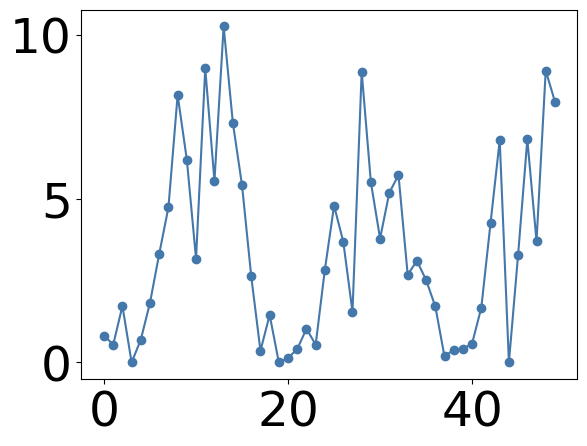

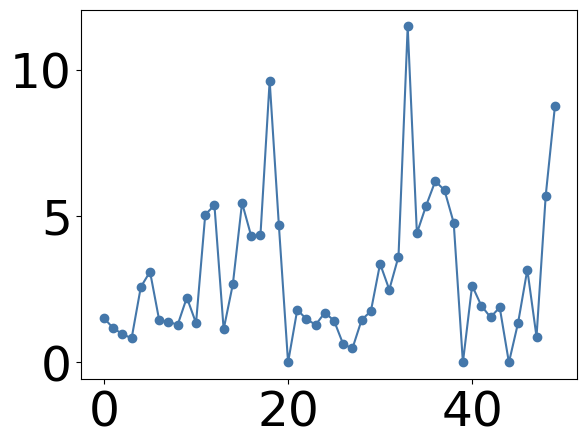

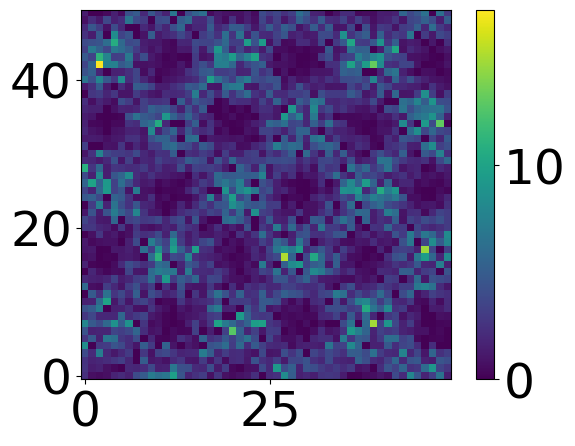

In [96]:
def data_reader(path,file,bins):
    f = open(path+file)
    lines = f.readlines()
    
    buffer = 35
    end = 256 + buffer
    lines = lines[buffer:end:]
    
    data = np.empty((256,bins))
    for i,l in enumerate(lines):
        data[i] = [float(i) for i in l.split()]
    f.close()
    
    return data

data = data_reader(r'C:\Users\samck\Documents\Scripts\McStas\Beamlines\CheckerboardSEMSANS\CB_SEM_20210714_224456',\
                  r'\xy_det.dat', 256)
plt.plot(data[100,50:100], 'o-')
plt.show()
plt.plot(data[50:100,100], 'o-')
plt.show()
plt.imshow(data[50:100,50:100], vmin=0, origin='lower', interpolation='none')
plt.colorbar()
plt.show()

Plotting data with name xy_det
Plotting data with name x_det
Plotting data with name y_det


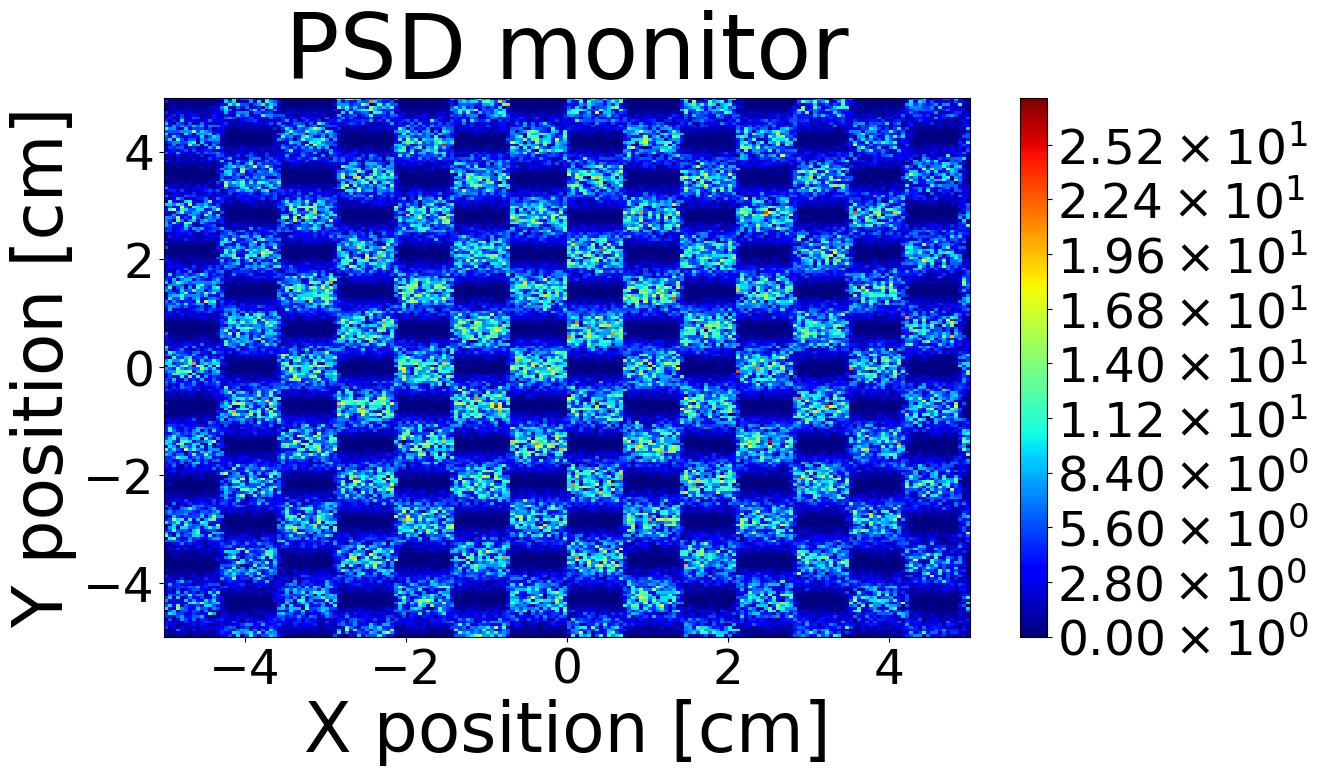

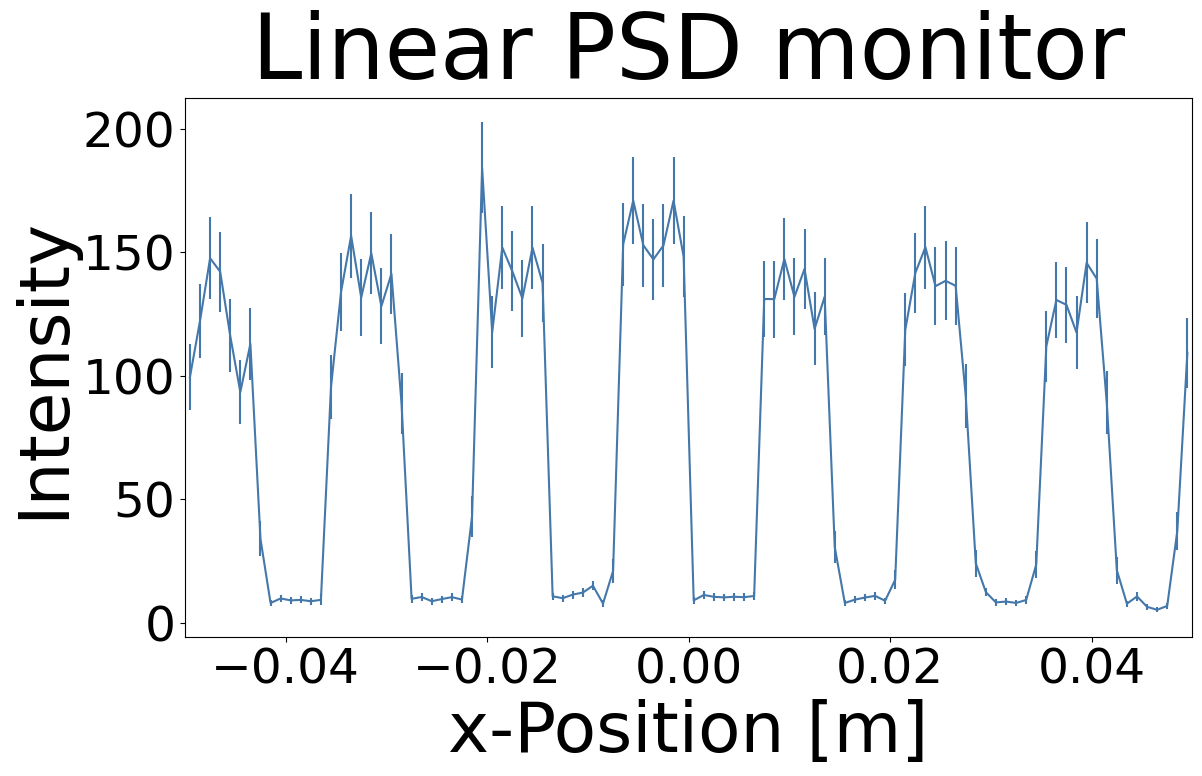

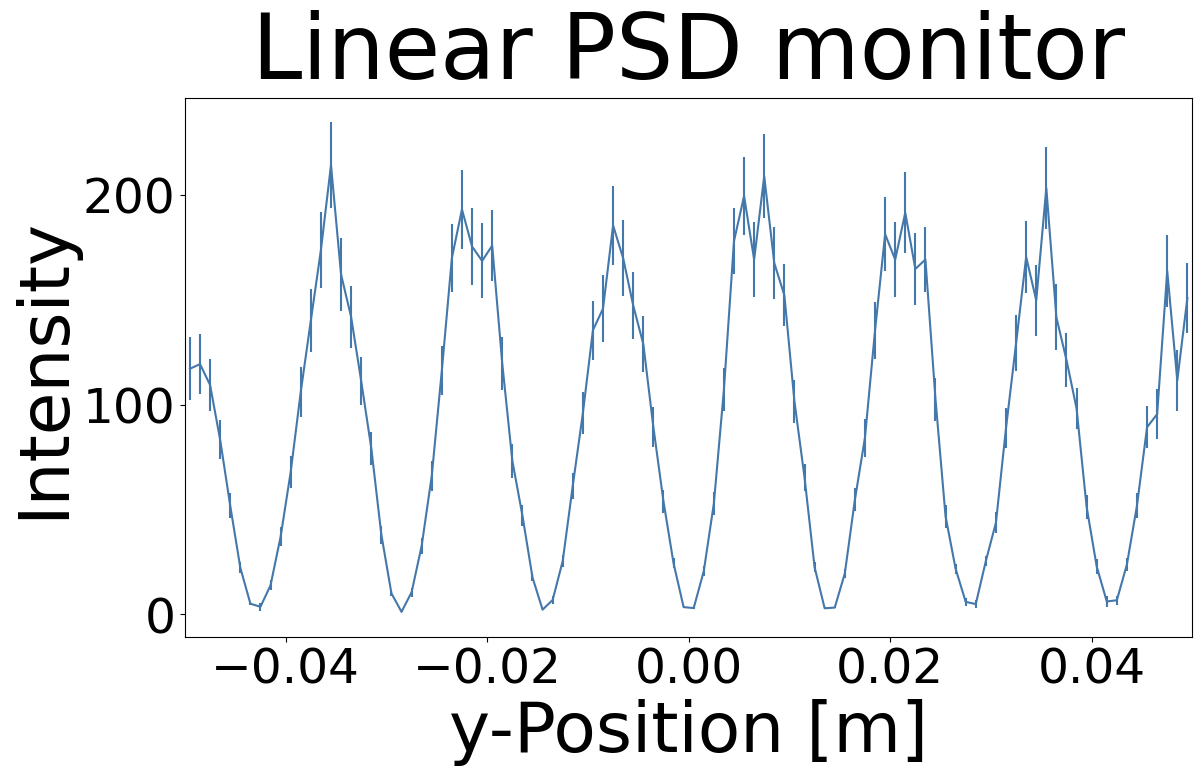

In [53]:
path = r'C:\Users\samck\Documents\Scripts\McStas\Beamlines\SEMSANS_CH_FIE\CB_SEM_FI_20210814_155621'
loaded_data = ms.load_data(path)
ms.make_plot(loaded_data)